In [209]:
import pandas as pd
import sklearn as sk
import matplotlib as plt
import numpy as np

In [210]:
# 1.1

df = pd.read_csv('loan_sanction_train.csv')
len(df)

# Il dataset ha 614 istanze


print(df.isnull().sum())
# Il dataset presenta missing values

df['Loan_Status'].value_counts()
# Il dataset è sbilanciato, sono molti di più i prestiti riscossi che quelli non riscossi




Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64


Y    422
N    192
Name: Loan_Status, dtype: int64

In [211]:
#1.2

female = df[df['Gender'] == 'Female']
female_count = female[female['Loan_Status'] == 'N']["Loan_Status"].count()
male = df[df['Gender'] == 'Male']
male_count = male[male['Loan_Status'] == 'N']["Loan_Status"].count()

print(male_count / male['Loan_Status'].count())
print(female_count / female['Loan_Status'].count())

# In generale le donne hanno una probabilità più alta di non ripagare il prestito

pivot_table = pd.pivot_table(df, values = "Loan_Status", columns = ["Gender", "Married"], aggfunc=lambda x: x.count() / df["Loan_Status"].count(), fill_value=0)
print(pivot_table)

# In tabella le percentuali di coloro che non rimborsano il prestito divisi per genere e stato civile


0.3067484662576687
0.33035714285714285
Gender         Female                Male          
Married            No       Yes        No       Yes
Loan_Status  0.130293  0.050489  0.211726  0.581433


Loan_Amount_Term     12.0      36.0      60.0      84.0      120.0     180.0  \
Loan_Status       0.001629  0.003257  0.003257  0.006515  0.004886  0.071661   

Loan_Amount_Term     240.0     300.0     360.0    480.0  
Loan_Status       0.006515  0.021173  0.833876  0.02443  


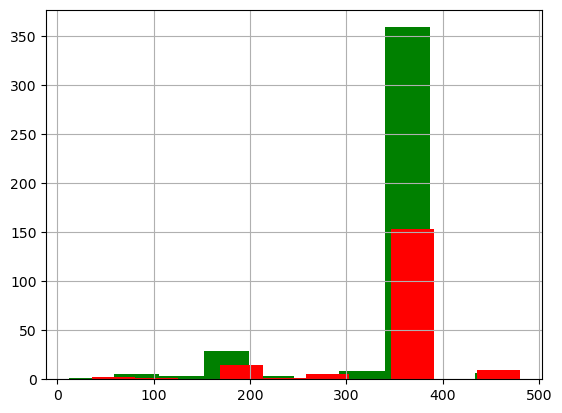

In [212]:
#1.3
# Plot the istogram of 'Loan_Amount_Term' for 'Loan_Status' = 'Y'
df[df['Loan_Status'] == 'Y']['Loan_Amount_Term'].hist(color='green')
df[df['Loan_Status'] == 'N']['Loan_Amount_Term'].hist(color='red')

# Print the percentage of 'Load_Status' = 'N' for each 'Loan_Amount_Term' in a table
pivot_table = pd.pivot_table(df, values = "Loan_Status", columns = ["Loan_Amount_Term"], aggfunc=lambda x: x.count() / df["Loan_Status"].count(), fill_value=0)
print(pivot_table)

# Non vi è una strettissima correlazione tra la durata del prestito e la probabilità di non riscuotere, ma in generare è vero che la maggior
# parte dei prestiti non riscossi sono quelli con durata più lunga

51.225812689798346


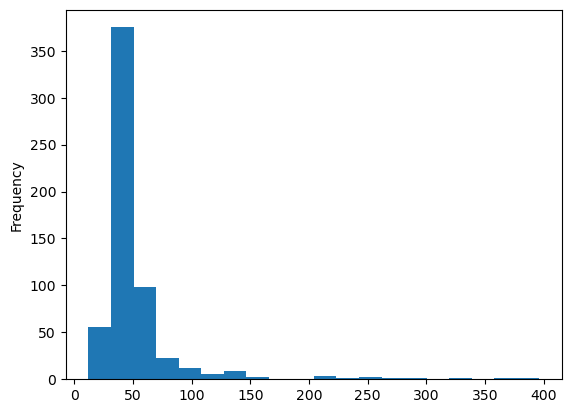

In [213]:
#1.4

df2 = df.copy()
df2['TotalIncome'] = df2['ApplicantIncome'] + df2['CoapplicantIncome']
df2["Income_Amout"] = df2["TotalIncome"] / df2["LoanAmount"]
df2["Income_Amout"].plot(kind='hist', bins=20)

print(df2["Income_Amout"].mean())

# La maggior parte dei prestiti si attesta su un rapporto tra reddito e prestito del 25-60%, in media il rapporto è del 50%

In [214]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def evaluate_model(name, model, X_train, X_test, y_train, y_test, metric):
    print("\n\nEvaluating model: " + name)
    model.fit(X_train, y_train)

    # Predict the test set and the train set
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    # Evaluate the model on the test set
    print("Accuracy Test set: ", metric(y_test, y_pred_test))
    print("Accuracy Train set: ", metric(y_train, y_pred_train))

    cm = confusion_matrix(y_test, y_pred_test)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()



Evaluating model: Decision Tree
Accuracy Test set:  0.725
Accuracy Train set:  1.0


Evaluating model: KNN
Accuracy Test set:  0.69375
Accuracy Train set:  0.73125


Evaluating model: Dummy
Accuracy Test set:  0.675
Accuracy Train set:  0.7


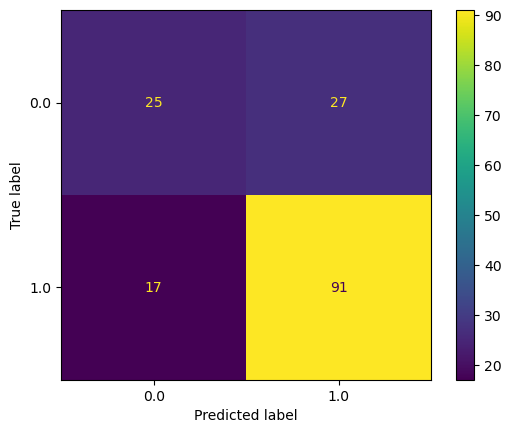

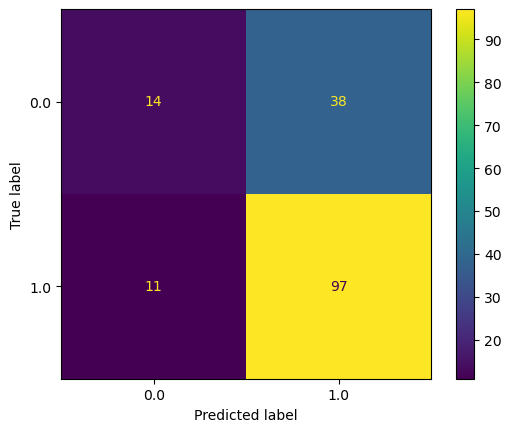

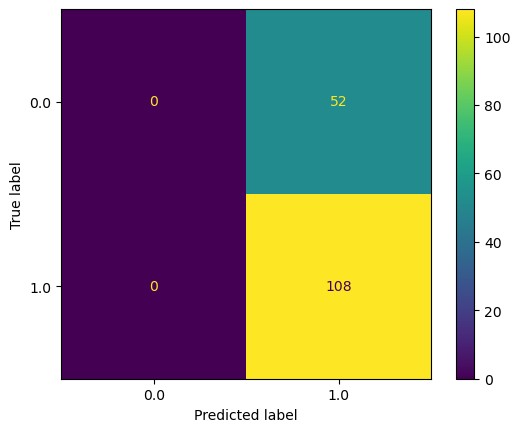

In [215]:
# 2.1
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier


df = pd.read_csv('loan_sanction_train.csv')
df.isnull().sum()
df['Loan_Status'].value_counts()
df = df.dropna()

df = df.drop(['Loan_ID'], axis=1)       # Eliminata la colonna Loan_ID in quanto ID, inutile per il modello

# Trasformo gli attributi in numerici tramite OrdinalEncoder

enc = OrdinalEncoder()
df = pd.DataFrame(enc.fit_transform(df), columns=df.columns)

X = df.drop(['Loan_Status'], axis=1)
y = df['Loan_Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/3)

clf = DecisionTreeClassifier()
evaluate_model("Decision Tree", clf, X_train, X_test, y_train, y_test, accuracy_score)

clf = KNeighborsClassifier()
evaluate_model("KNN", clf, X_train, X_test, y_train, y_test, accuracy_score)

clf = DummyClassifier(strategy="most_frequent")
evaluate_model("Dummy", clf, X_train, X_test, y_train, y_test, accuracy_score)

# Il decision tree raggiunge l'accuracy più alta ma probabilmente overfitta (100% sul training set) mentre il KNN tende a predire di più
# i prestiti riscossi in quanto sono più numerosi nel dataset. Dalla confusion matrix si vede che il decision tree è più bilanciato negli errori
# mentre il KNN raramente predice correttamente i prestiti non riscossi

# Considerando quanto è sbilanciato il dataset, si raggiunge una accuracy maggiore con il Dummy Classifier piuttosto che con KNN

In [216]:
# 2.2
from sklearn.model_selection import cross_val_score

clf = DecisionTreeClassifier()
scores = cross_val_score(clf, X, y, cv=10)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

clf = KNeighborsClassifier()
scores = cross_val_score(clf, X, y, cv=10)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

clf = DummyClassifier(strategy="most_frequent")
scores = cross_val_score(clf, X, y, cv=10)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# I risultati non cambiano utilizzando un 10-fold cross validation

Accuracy: 0.71 (+/- 0.15)
Accuracy: 0.66 (+/- 0.09)
Accuracy: 0.69 (+/- 0.02)


In [217]:
# 2.3

from sklearn.model_selection import GridSearchCV

parameters = {
    'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance']
}

clf = KNeighborsClassifier()
grid_search = GridSearchCV(clf, parameters, cv=10)

grid_search.fit(X, y)

print(grid_search.best_params_)
print(grid_search.best_score_)


# L'accuratezza con i parametri migliori supera di poco (0.681 contro 0.668) quella ottenuta con i parametri di default

{'n_neighbors': 15, 'weights': 'uniform'}
0.68125


112.0
104.0


Evaluating model: Decision Tree
Accuracy Test set:  0.6625
Accuracy Train set:  0.76875


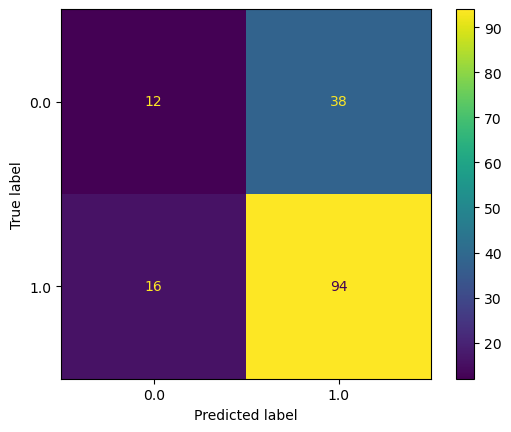

In [218]:
# 2.4

df2 = df.copy()
X = df2.drop(['Loan_Status'], axis=1)
y = df2['Loan_Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/3)

model = DecisionTreeClassifier(random_state = 124)
model.fit(X_train, y_train)

X_test["Gender"] = 0
y_pred_test_male = model.predict(X_test)

X_test["Gender"] = 1
y_pred_test_female = model.predict(X_test)

print(y_pred_test_female.sum())
print(y_pred_test_male.sum())

# Il modello è neutrale rispetto al genere in quanto, anche forzando il genere a maschile o femminile, la previsione non varia significativamente

df2 = df.copy()
df2 = df2.drop(['Gender'], axis=1)

X = df2.drop(['Loan_Status'], axis=1)
y = df2['Loan_Status']

#TODO: Il modo corretto per valutare se il modello è fair, è eliminare la colonna "Gender" dal train set e poi allenare il modello
# Fatto questo, si prende il test set (che conserva ancora la colonna in questione) e si selezionano prima solo i maschi e poi solo le femmine
# (Eliminando la colonna "Gender" dopo aver selezionato le colonne e prima di darle al modello) e si valuta l'accuratezza del modello
# Se l'accuratezza è simile, il modello è fair, altrimenti no

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/3)

model = DecisionTreeClassifier(random_state = 124)
evaluate_model("Decision Tree", clf, X_train, X_test, y_train, y_test, accuracy_score)

# L'accuratezza del modello aumenta leggermente rispetto al caso di default (0.71 contro 0.70) ma la rimozione del genere non ha un impatto significativo
# Questo riafferma ulteriormente quanto detto sopra, l'attributo "Gender" non è determinante per la previsione finale



Evaluating model: Pipeline 1
Accuracy Test set:  0.73125
Accuracy Train set:  0.809375


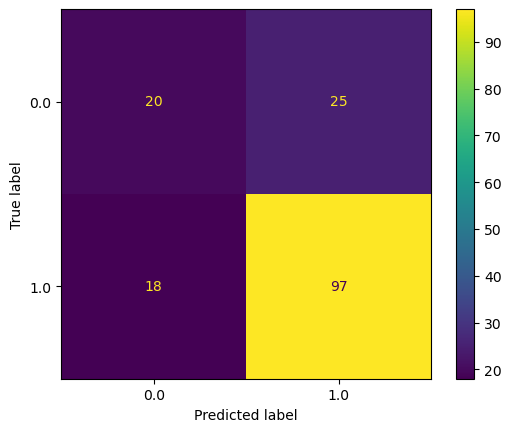

In [225]:
# 2.5
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import Normalizer, KBinsDiscretizer
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

df = pd.read_csv('loan_sanction_train.csv')
df.isnull().sum()
df['Loan_Status'].value_counts()

df = df.drop(['Loan_ID'], axis=1)       # Eliminata la colonna Loan_ID in quanto ID, inutile per il modello

# Definizione elementi pipeline
imputer = SimpleImputer(strategy='most_frequent')
normalizer = Normalizer()
encoder = OrdinalEncoder()
discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
selector = SelectKBest(k=5)
model = KNeighborsClassifier()

X = df2.drop(['Loan_Status'], axis=1)
y = df2['Loan_Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/3)

norm_index = [X.columns.get_loc(c) for c in X.columns if c in ['Dependents', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']]
encoder_index = [X.columns.get_loc(c) for c in X.columns if c in ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']]
discretizer_index = [X.columns.get_loc(c) for c in X.columns if c in ['LoanAmount']]

preprocessor = ColumnTransformer(transformers=[
    ('normalizer', normalizer, norm_index),
    ('encoder', encoder, encoder_index),
    ('discretizer', discretizer, discretizer_index)
])

# Definizione pipeline
pipeline = Pipeline(steps = [
    ('imputer', imputer),
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('model', model)
    ], verbose=False
)



# Use the pipeline to fit a model on the training set
pipeline.fit(X_train, y_train)
evaluate_model("Pipeline 1", pipeline, X_train, X_test, y_train, y_test, accuracy_score)

# L'accuracy migliora rispetto al modello di default di KNN (0.73 contro 0.66)

In [221]:
# 2.6

parameters = {
    'model__n_neighbors': [1, 3, 5, 6],
    'model__weights': ['uniform', 'distance'],
    'preprocessor__discretizer__n_bins': [4, 5, 6],
    'selector__k': [5, 6, 7]
}

grid_search = GridSearchCV(pipeline, parameters, cv=10)
grid_search.fit(X, y)

print(grid_search.best_params_)
print(grid_search.best_score_)

# I parametri migliori risultano essere:
# {'model__n_neighbors': 5, 'model__weights': 'uniform', 'preprocessor__discretizer__n_bins': 6, 'selector__k': 5}
# 0.702

{'model__n_neighbors': 5, 'model__weights': 'uniform', 'preprocessor__discretizer__n_bins': 6, 'selector__k': 5}
0.7020833333333334
